In [15]:
import torch
from esm import pretrained
%load_ext autoreload
import seaborn as sns

# ESM single sequence (esm2_t30_150M_UR50D)

## Example Use

In [ ]:
def mask(sequence, masked_index):
    """
    Replaces a character at the specified index with a mask token ('X').
    
    Parameters:
        sequence (str): The original sequence.
        masked_index (int): The index of the character to mask.

    Returns:
        list of tuples: Each tuple is a sequence identifier and sequence (required by batch_converter).
    """
    if isinstance(masked_index, int):
        return sequence[:masked_index] + '<mask>' + sequence[masked_index + 1:]
    elif isinstance(masked_index, list):
        masked_sequence=sequence
        for i in masked_index:
            masked_sequence = masked_sequence[:i] + 'X' + masked_sequence[i + 1:]
        return masked_sequence.replace('X', '<mask>')

In [125]:
sequence="MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
model, alphabet = pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_indices=[4,5,6,7,9,17,45]
masked_sequence=mask(sequence, masked_indices)
print(f'Masking residues:\n{sequence}\n{masked_sequence.replace("<mask>","X")}\n{"".join(["-" if sequence[i]==masked_sequence.replace("<mask>","X")[i] else "^" for i in range(len(sequence))])}')

Masking residues:
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSXXXXTXVKAAWGKXGAHAGEYGAEALERMFLSFPTTKTYFPXFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
----^^^^-^-------^---------------------------^------------------------------------------------------------------------------------------------


In [130]:
batch_labels, batch_strs, batch_tokens = batch_converter([('ID',masked_sequence)])
batch_tokens = batch_tokens.to(device)

# Perform inference
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[10])
predicted_sequence="".join([alphabet.get_tok(item) for item in results["logits"][0].argmax(dim=-1)[1:-1]])
print(f'{sequence}\n{predicted_sequence}\n{"".join(["_" if sequence[i]==predicted_sequence[i] else "^" for i in range(len(sequence))])}')

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSAAEKTLVKAAWGKVGAHAGEYGAEALERMFLSFPWTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDLPAALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASWDKFLASVSTVLTSKYR
____^_^__^____________________________^_____________________________________^_^______________________________________________^________________


Interestingly unmasked have changed as well. These changes to non-masked residues occur because:
- The model predicts all residues simultaneously, not just the masked ones.
- Contextual changes caused by masking can slightly influence predictions for non-masked positions.
This can be fixed a so:

In [111]:
predicted_sequence = list(sequence)  # Start with the original sequence
for idx in masked_indices:
    predicted_token_id = results["logits"][0, idx + 1].argmax().item()  # Offset by 1 for padding
    predicted_token = alphabet.get_tok(predicted_token_id)
    predicted_sequence[idx] = predicted_token  # Replace only the masked positions
predicted_sequence = ''.join(predicted_sequence)
print(f'{sequence}\n{predicted_sequence}\n{"".join(["^" if sequence[i]!=predicted_sequence[i] else "-" if masked_sequence.replace("<mask>","X")[i]=="X" else "_" for i in range(len(sequence))])}')

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSAAEKTLVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
____^-^-_^_______-___________________________-________________________________________________________________________________________________


## Testing with a batch

In [87]:
#sequences=utils.read_fasta('Project2/BindingDBTargetSequences.fasta')[::4000]
sequences=['MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR',
 'MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR',
 'MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSALSKLSELHAYVLRVDPVNFKFLSHCLLVTLASHFPADFTADAHAAWDKFLSIVSGVLTEKYR']
model, alphabet = pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masked_indices=[10,40,60]
batch_labels, batch_strs, batch_tokens = batch_converter([('ID',mask(seq,masked_indices)) for seq in sequences])
batch_tokens = batch_tokens.to(device)

# Perform inference
with torch.no_grad():
    results = model(batch_tokens)
predictions=["".join([alphabet.get_tok(item) for item in seq if item!=0 and item!=2]) for seq in results["logits"].argmax(dim=-1)]


In [88]:
# Test
s=0
for label,pred in zip(sequences,predictions):
    print(f'{label}\n{pred}\n{"".join(["^" if label[i]!=pred[i] and i in masked_indices else "-" if i in masked_indices else "_" for i in range(len(label))])}')
    for i in masked_indices:
        s+=pred[i]==label[i]
s/(len(sequences)*len(masked_indices))

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPWTKTYFPHFDLSHGSAQVKGHGAKVADALTNAVAHVDDLPAALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASWDKFLASVSTVLTSKYR
__________-_____________________________-___________________^_________________________________________________________________________________
MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
MVLSGEDKSNVKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGAKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
__________^_____________________________-___________________^_________________________________________________________________________________
MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSALSKLSELHAYVLRVDPVNFKFLSHCLLVTLASHFPADFTADAHAAWDKFLSIVSGVLTEKYR

0.4444444444444444

# ESM for MSAs as input (esm_msa1b_t12_100M_UR50S)

In [113]:
# Load the MSA model and alphabet
model, alphabet = pretrained.esm_msa1b_t12_100M_UR50S()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
msa = [
    ('sp|P69905|HBA_HUMAN','MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR'),
    ('sp|P01942|HBA_MOUSE','MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR'),
    ('sp|P13786|HBAZ_CAPHI','MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSALSKLSELHAYVLRVDPVNFKFLSHCLLVTLASHFPADFTADAHAAWDKFLSIVSGVLTEKYR'),
]

In [114]:
masked_indices=[10,40,60]
msa_with_mask = [(pair[0], utils.mask(pair[1], masked_index=masked_indices)) for pair in msa]
batch_labels, batch_strs, batch_tokens = batch_converter([msa_with_mask])
batch_tokens = batch_tokens.to(device)

In [115]:
# Perform inference
results = model(batch_tokens)
predictions=["".join([alphabet.get_tok(item) for item in seq[1:] if item!=0 and item!=2]) for seq in results['logits'][0].argmax(dim=-1)]

for (id, seq), pred in zip(msa,predictions):
    print(f'{id}\n{seq}\n{pred[:len(seq)]}\n{"".join(["^" if seq[i]!=pred[i] else "-" if i in masked_indices else "_" for i in range(len(seq))])}')

sp|P69905|HBA_HUMAN
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPEDKTNLKAAWGKVGAHAGEYGAEALERMFASFPTTATYFPHFDLSHGSAQVKGHGAKVADALTNAVAHVDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHHPADFTPAVHASLDKFLASVSTVLTSKYR
_____^____^_______________________^_____^___________________^_______________^_^__________________________________^__^_________________________
sp|P01942|HBA_MOUSE
MVLSGEDKSNIKAAWGKIGGHGAEYGAEALERMFASFPTTKTYFPHFDVSHGSAQVKGHGKKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHHPADFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKSNLKAAWGKIGGHAAEYGAEALERMFASFPTTATYFPHFDLSHGSAQVKGHGAKVADALASAAGHLDDLPGALSALSDLHAHKLRVDPVNFKLLSHCLLVTLASHLPADFTPAVHASLDKFLASVSTVLTSKYR
____^^____^__________^__________________^_______^___________^____________________________________________________^____________________________
sp|P13786|HBAZ_CAPHI
MSLTRTERTIILSLWSKISTQADVIGTETLERLFSCYPQAKTYFPHFDLHSGSAQLRAHGSKVVAAVGDAVKSIDNVTSAL

# Visualising Attention

In [74]:
sequence="MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
model, alphabet = pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_labels, batch_strs, batch_tokens = batch_converter([('ID',sequence)])
batch_tokens = batch_tokens.to(device)

# Perform inference
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[10],need_head_weights=True)
predicted_sequence="".join([alphabet.get_tok(item) for item in results["logits"][0].argmax(dim=-1)[1:-1]])
print(f'{sequence}\n{predicted_sequence}\n{"".join(["_" if sequence[i]==predicted_sequence[i] else "^" for i in range(len(sequence))])}')

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
______________________________________________________________________________________________________________________________________________


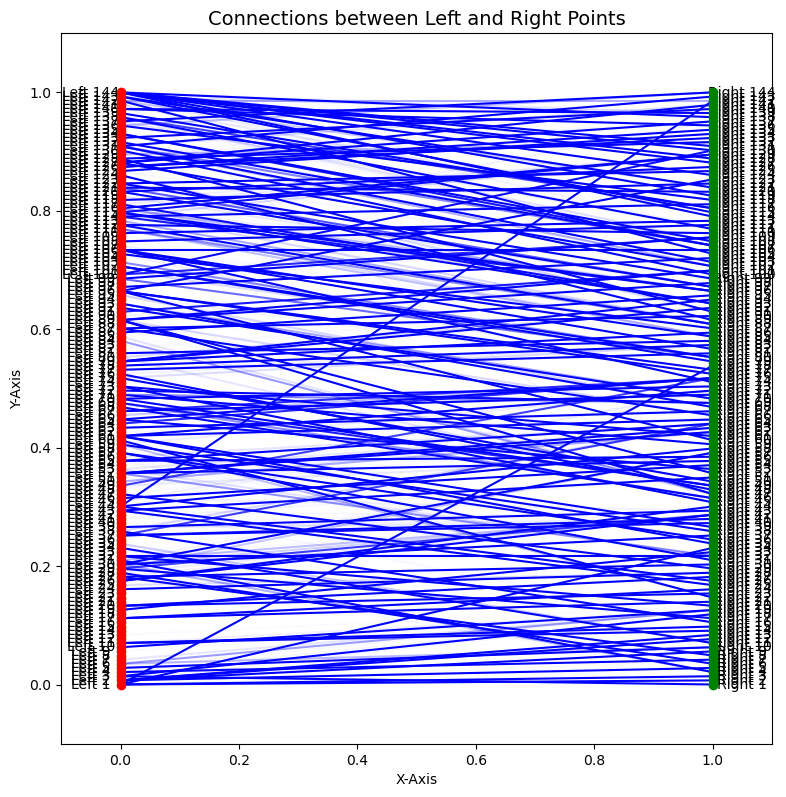

In [106]:
import matplotlib.pyplot as plt
import numpy as np

matrix=results['attentions'].squeeze()[0,0].numpy()#.shape#.mean(dim=(0, 1)).sum(dim=0)   
matrix=matrix/matrix.max(axis=0) 

# Number of points on the left and right
n_points = matrix.shape[0]

# Define y-values for the points (same for both sides for simplicity)
y_values_left = np.linspace(0, 1, n_points)  # Left points' y-values
y_values_right = np.linspace(0, 1, n_points)  # Right points' y-values

# Define x-values for left and right points
x_left = np.zeros(n_points)  # All points on the left will have x = 0
x_right = np.ones(n_points)  # All points on the right will have x = 1

# Create the plot
plt.figure(figsize=(8, 10))

# Loop through all points on the left and right
for i in range(n_points):
    for j in range(n_points):
        # Draw a line connecting each point on the left to each point on the right
        plt.plot([x_left[i], x_right[j]], [y_values_left[i], y_values_right[j]], color='b', alpha=(matrix[i,j]**100 if ))

# Optional: Plot the points on the left and right
plt.scatter(x_left, y_values_left, color='red', zorder=5)  # Red points on the left
plt.scatter(x_right, y_values_right, color='green', zorder=5)  # Green points on the right

# Add labels for clarity
for i in range(n_points):
    plt.text(x_left[i] - 0.05, y_values_left[i], f'Left {i+1}', ha='center', va='center', fontsize=10)
    plt.text(x_right[i] + 0.05, y_values_right[i], f'Right {i+1}', ha='center', va='center', fontsize=10)

# Customize plot
plt.title("Connections between Left and Right Points", fontsize=14)
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.xlim(-0.1, 1.1)  # Make sure both sides are visible
plt.ylim(-0.1, 1.1)  # Adjust Y-axis to fit the points
plt.gca().set_aspect('equal', adjustable='box')  # Keep aspect ratio equal for better visualization

# Show plot
plt.tight_layout()
plt.show()


# Embedding Visulisation

In [17]:
import torch
from esm import pretrained

# Load the pre-trained ESM model (e.g., ESM-2)
#model_name = "esm2_t6_8M_UR50D"  # Choose a smaller model for efficiency, or larger for better quality
model, alphabet = pretrained.esm2_t30_150M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # Set the model to evaluation mode

# Define amino acids and their sequences
amino_acids = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I",
               "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V",
                ]
sequences = [(aa, aa) for aa in amino_acids]  # Each amino acid as its own sequence

# Prepare the input batch
batch_labels, batch_strs, batch_tokens = batch_converter(sequences)

# Forward pass to get embeddings
with torch.no_grad():
    # Extract per-token embeddings from the model
    results = model(batch_tokens, repr_layers=[0])  # Layer 33 is often used for embeddings in ESM
    token_embeddings = results["representations"][0]  # Shape: [batch_size, seq_len, embedding_dim]

# Extract embeddings for each amino acid
aa_embeddings = []
for i, aa in enumerate(amino_acids):
    # Token 1 corresponds to the amino acid (ignoring start/end tokens)
    embedding = token_embeddings[i, 1, :].numpy()
    aa_embeddings.append(embedding)

# Convert to numpy array for easier manipulation
import numpy as np
aa_embeddings = np.array(aa_embeddings)

# Save or use the embeddings
print("Shape of embeddings:", aa_embeddings.shape)  # Should be (20, embedding_dim)


Shape of embeddings: (20, 640)


In [18]:
hydrophobicity = {
    'I': 4.5,'V': 4.2,'L': 3.8,'F': 2.8,'C': 2.5,
    'M': 1.9,'A': 1.8,'G': -0.4,'T': -0.7,'S': -0.8,
    'W': -0.9,'Y': -1.3,'P': -1.6,'H': -3.2,'E': -3.5,
    'Q': -3.5,'D': -3.5,'N': -3.5,'K': -3.9,'R': -4.5
}
molecular_weight = {
    'A': 89.09, 'R': 174.2, 'N': 132.12, 'D': 133.1, 'C': 121.15,
    'Q': 146.15, 'E': 147.13, 'G': 75.07, 'H': 155.16, 'I': 131.18,
    'L': 131.18, 'K': 146.19, 'M': 149.21, 'F': 165.19, 'P': 115.13,
    'S': 105.09, 'T': 119.12, 'W': 204.23, 'Y': 181.19, 'V': 117.15
}
polarity = {
    'A': 8.1, 'R': 10.5, 'N': 11.6, 'D': 13.0, 'C': 5.5,
    'Q': 10.5, 'E': 12.3, 'G': 9.0, 'H': 10.4, 'I': 5.2,
    'L': 4.9, 'K': 11.3, 'M': 5.7, 'F': 5.2, 'P': 8.0,
    'S': 9.2, 'T': 8.6, 'W': 5.4, 'Y': 6.2, 'V': 5.9
}
pka = {
    'A': None, 'R': 12.48, 'N': None, 'D': 3.65, 'C': 8.18,
    'Q': None, 'E': 4.25, 'G': None, 'H': 6.00, 'I': None,
    'L': None, 'K': 10.53, 'M': None, 'F': None, 'P': None,
    'S': None, 'T': None, 'W': None, 'Y': 10.07, 'V': None
}
pi = {
    'A': 6.00, 'R': 10.76, 'N': 5.41, 'D': 3.90, 'C': 5.07,
    'Q': 5.65, 'E': 3.22, 'G': 6.06,'H': 7.59, 'I': 6.02, 
    'L': 6.04, 'K': 9.60, 'M': 5.74, 'F': 5.48, 'P': 6.30, 
    'S': 5.68,'T': 5.60, 'W': 5.89, 'Y': 5.66, 'V': 6.00
}
phosphorylation = {
    'A': 0, 'R': 0, 'N': 0, 'D': 0, 'C': 0, 'Q': 0, 'E': 0, 'G': 0,
    'H': 0, 'I': 0, 'L': 0, 'K': 0, 'M': 0, 'F': 0, 'P': 0, 'S': 1,
    'T': 1, 'W': 0, 'Y': 1, 'V': 0
}
h_bond = {
    'A': 0, 'R': 1, 'N': 1, 'D': 1, 'C': 1, 'Q': 1, 'E': 1, 'G': 0,
    'H': 1, 'I': 0, 'L': 0, 'K': 1, 'M': 0, 'F': 0, 'P': 0, 'S': 1,
    'T': 1, 'W': 1, 'Y': 1, 'V': 0
}
h_bond_num = {
    'A': 0,  # Alanine: No potential for H-bonds in the side chain
    'R': 3,  # Arginine: Can form 3 H-bonds due to its guanidinium group
    'N': 2,  # Asparagine: Can form 2 H-bonds due to its amide side chain
    'D': 1,  # Aspartic Acid: Can form 1 H-bond via the carboxyl group
    'C': 1,  # Cysteine: Can form 1 H-bond via the thiol group (-SH) in some contexts
    'Q': 2,  # Glutamine: Can form 2 H-bonds due to its amide side chain
    'E': 1,  # Glutamic Acid: Can form 1 H-bond via the carboxyl group
    'G': 0,  # Glycine: No potential for H-bonds in the side chain
    'H': 2,  # Histidine: Can form 2 H-bonds via its imidazole ring
    'I': 0,  # Isoleucine: No potential for H-bonds in the side chain
    'L': 0,  # Leucine: No potential for H-bonds in the side chain
    'K': 2,  # Lysine: Can form 2 H-bonds via the amino group (-NH2)
    'M': 0,  # Methionine: No potential for H-bonds in the side chain
    'F': 0,  # Phenylalanine: No potential for H-bonds in the side chain
    'P': 0,  # Proline: No potential for H-bonds in the side chain
    'S': 1,  # Serine: Can form 1 H-bond due to its hydroxyl group (-OH)
    'T': 1,  # Threonine: Can form 1 H-bond due to its hydroxyl group (-OH)
    'W': 2,  # Tryptophan: Can form 2 H-bonds due to the nitrogen in its indole ring
    'Y': 1,  # Tyrosine: Can form 1 H-bond due to its hydroxyl group (-OH)
    'V': 0   # Valine: No potential for H-bonds in the side chain
}
flexibility = {
    'A': 1,  # Alanine: Flexible, often found in alpha helices
    'R': 0,  # Arginine: More constrained due to large side chain
    'N': 1,  # Asparagine: Flexible
    'D': 0,  # Aspartic Acid: More constrained due to acidic side chain
    'C': 1,  # Cysteine: Flexible, can form disulfide bonds
    'Q': 1,  # Glutamine: Flexible
    'E': 0,  # Glutamic Acid: More constrained
    'G': 1,  # Glycine: Highly flexible due to smallest side chain
    'H': 1,  # Histidine: Flexible, often found in turns
    'I': 0,  # Isoleucine: More rigid
    'L': 0,  # Leucine: More rigid
    'K': 1,  # Lysine: Flexible, basic side chain can interact
    'M': 1,  # Methionine: Flexible
    'F': 0,  # Phenylalanine: More rigid due to aromatic ring
    'P': 0,  # Proline: Highly rigid, often found in turns
    'S': 1,  # Serine: Flexible, can form hydrogen bonds
    'T': 1,  # Threonine: Flexible, can form hydrogen bonds
    'W': 0,  # Tryptophan: More rigid, aromatic ring
    'Y': 1,  # Tyrosine: Flexible, can form hydrogen bonds
    'V': 0   # Valine: More rigid
}
structure = {
    'A': 'helix',   # Alanine
    'R': 'turn',    # Arginine
    'N': 'sheet',   # Asparagine
    'D': 'sheet',   # Aspartic Acid
    'C': 'helix',   # Cysteine
    'Q': 'sheet',   # Glutamine
    'E': 'sheet',   # Glutamic Acid
    'G': 'turn',    # Glycine
    'H': 'helix',   # Histidine
    'I': 'helix',   # Isoleucine
    'L': 'helix',   # Leucine
    'K': 'turn',    # Lysine
    'M': 'helix',   # Methionine
    'F': 'sheet',   # Phenylalanine
    'P': 'turn',    # Proline
    'S': 'helix',   # Serine
    'T': 'helix',   # Threonine
    'W': 'sheet',   # Tryptophan
    'Y': 'sheet',   # Tyrosine
    'V': 'helix'    # Valine
}

properties=[hydrophobicity,molecular_weight,polarity,h_bond_num]

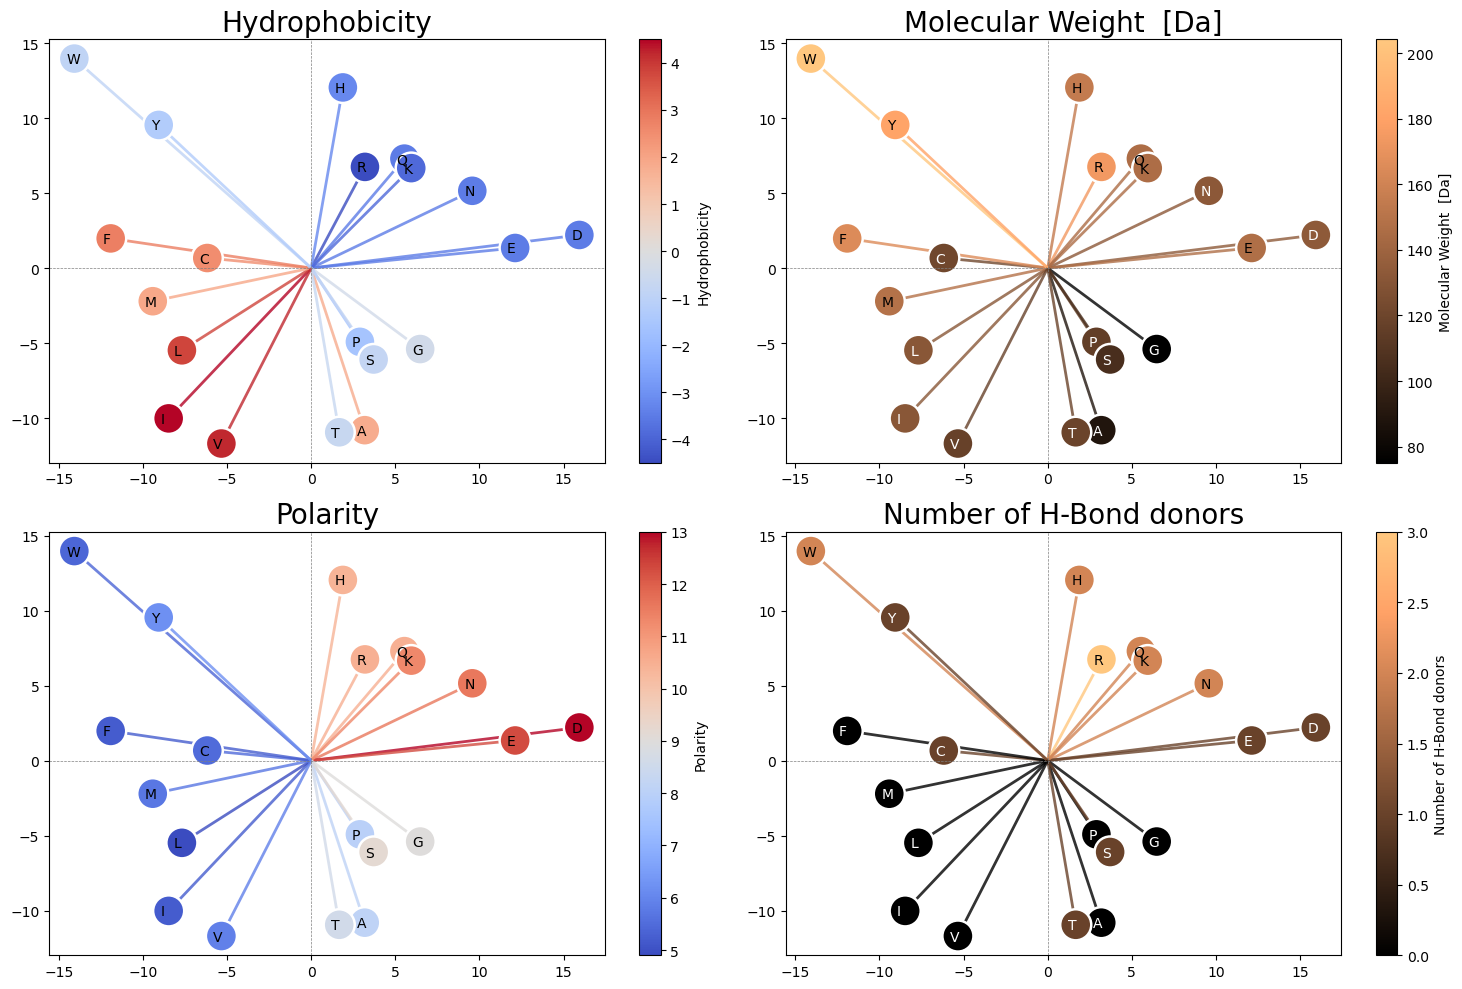

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_data=PCA(n_components=2, random_state=0).fit_transform(StandardScaler().fit_transform(aa_embeddings))


# Assume 'pca_data', 'hydrophobicity', 'molecular_weight', 'polarity', and 'amino_acids' are predefined
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Define the property names and dictionaries
properties = [hydrophobicity, molecular_weight, polarity, h_bond_num]
property_names = ['Hydrophobicity', 'Molecular Weight  [Da]', 'Polarity', 'Number of H-Bond donors']
palettes = [plt.cm.coolwarm, plt.cm.copper, plt.cm.coolwarm, plt.cm.copper]

for ax, property_dict, name, palette in zip(axes.flatten(), properties, property_names, palettes):
    # Property values (used for color)
    hue_values = [property_dict[aa] for aa in amino_acids]
    
    # Plot vectors from origin (0, 0) to each point
    for i, (x, y) in enumerate(pca_data):
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, 
                  color=palette((hue_values[i] - min(hue_values)) / (max(hue_values) - min(hue_values))),
                  alpha=0.8, width=0.005)
    
    # Scatter plot to overlay points (optional)
    scatter = sns.scatterplot(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        hue=hue_values,  # Use the property for hue
        s=500,
        ax=ax,
        palette=palette,
        legend=None  # Remove legend
    )
    
    # Add colorbar to the plot
    norm = plt.Normalize(vmin=min(hue_values), vmax=max(hue_values))
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])  # Empty array for the colorbar
    cbar = ax.figure.colorbar(sm, ax=ax)
    cbar.set_label(name)
    
    
    # Add text labels for amino acids
    for i, label in enumerate(amino_acids):
        ax.text(pca_data[i, 0] - 0.48, pca_data[i, 1] - 0.3, label, fontsize=10, color = 'black' if name =='Polarity' or name =='Hydrophobicity' else ('black' if np.abs(hue_values[i]) > np.mean(hue_values)+1 else 'white'))
    
    ax.set_title(name, size=20)
    ax.axhline(0, color='gray', linewidth=0.5, linestyle='--')  # Optional: Add origin axes
    ax.axvline(0, color='gray', linewidth=0.5, linestyle='--')

plt.tight_layout()
plt.show()

# Bertviz

In [76]:
import numpy as np
sequence="MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR"
model, alphabet = pretrained.esm2_t6_8M_UR50D()
batch_converter = alphabet.get_batch_converter()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_labels, batch_strs, batch_tokens = batch_converter([('ID',sequence)])
batch_tokens = batch_tokens.to(device)

# Perform inference
with torch.no_grad():
    results = model(batch_tokens, repr_layers=np.arange(10),need_head_weights=True)
predicted_sequence="".join([alphabet.get_tok(item) for item in results["logits"][0].argmax(dim=-1)[1:-1]])
print(f'{sequence}\n{predicted_sequence}\n{"".join(["_" if sequence[i]==predicted_sequence[i] else "^" for i in range(len(sequence))])}')

MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR
______________________________________________________________________________________________________________________________________________


In [ ]:
from bertviz import model_view, head_view
attention = results['attentions']#.squeeze()
tokens=[alphabet.get_tok(item) for item in batch_tokens.squeeze()]
head_view(attention.permute(1, 0, 2, 3, 4).view(6, 1, 20, 48, 3, 48, 3).sum(dim=(-1, -3)), [''.join([str(i),': ']+tokens[i:i+3]) for i in range(0, len(tokens), 3)])

In [ ]:
from bertviz import model_view, head_view
attention = results['attentions']#.squeeze()
tokens=[alphabet.get_tok(item) for item in batch_tokens.squeeze()]
head_view(attention.permute(1, 0, 2, 3, 4), tokens)